In [1]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tsfeature as tsf
from sklearn.neighbors import NearestNeighbors

my_path = os.path.abspath('')
my_path = my_path.split('\\')
my_path_py = "\\".join(my_path[:-1])
my_path_py

'C:\\Users\\gioma\\Documents\\GitHub\\Tesis_Fiuna\\Paraguay'

# Epsilon para RawBased ----------------------------------------------------------------------

In [2]:
dataset = pd.read_csv(my_path_py+'\\DatosRaw\\timeSeries_Incidencia_2009al2013.csv', sep=',')
dataset = dataset.drop('Unnamed: 0', axis=1)

In [3]:
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(dataset)
distances, indices = neighbors_fit.kneighbors(dataset)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

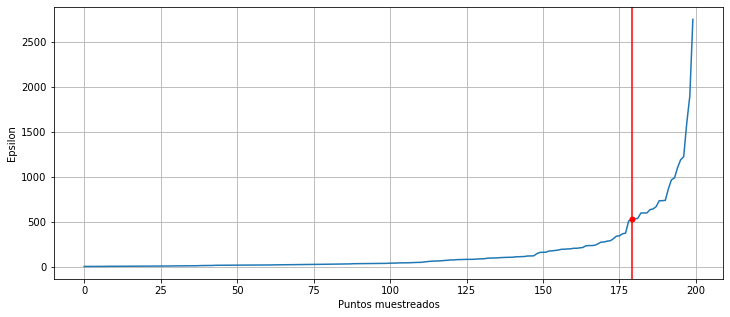

In [8]:
plt.figure(figsize=(12, 5))
plt.ylabel('Epsilon')
plt.xlabel('Puntos muestreados')
plt.grid('on')
plt.plot(distances)
plt.plot(178, np.interp(178, list(range(len(distances))), distances), marker='.', color='r', markersize=10)
plt.axvline(x=178, color='r')
plt.savefig(my_path_py + '/Pictures/Epsilon1RawBased.png')

In [10]:
np.interp(178, list(range(len(distances))), distances)

506.1363924169053

In [28]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

corr_dist = pd.read_csv(my_path_py+'\\1_RawBased\\MatrizPearson_RB.csv', sep=',')
corr_dist = corr_dist.to_numpy()

scorr_dist = pd.read_csv(my_path_py+'\\1_RawBased\\MatrizSpearman_RB.csv', sep=',')
scorr_dist = scorr_dist.to_numpy()

DB_corr = DBSCAN(eps=0.3, min_samples=4).fit_predict(scorr_dist)
sil = silhouette_score(scorr_dist, DB_corr)
print(sil)

0.3749327951161568


# Epsilon para FeatureBased ------------------------------------------------------

In [8]:
dataset_FB = pd.read_csv(my_path_py+'\\2_FeatureBased\\FB2_2009al2013.csv', sep=',')
dataset_FB = dataset_FB.drop('Unnamed: 0', axis=1)
dataset_FB = dataset_FB.drop('Distrito', axis=1)

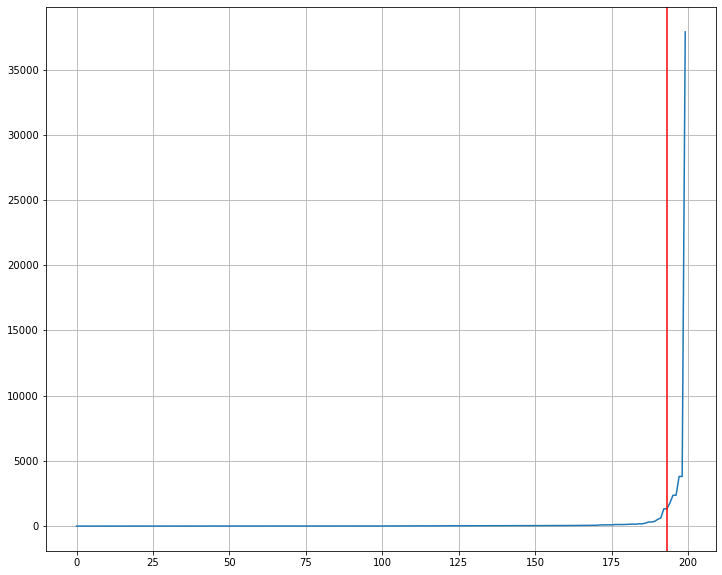

In [9]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(dataset_FB)
distances, indices = neighbors_fit.kneighbors(dataset_FB)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(12, 5))
plt.plot(distances)
plt.grid(True)
plt.axvline(x=193, color='r')
plt.savefig(my_path_py + '/Pictures/Epsilon1FeatureBased.png')

In [ ]:
corr_dist = pd.read_csv(my_path_py+'\\1_RawBased\\MatrizPearson_FB.csv', sep=',')
corr_dist = corr_dist.to_numpy()

epsilon_lista = [0.01, 0.01, 0.5, 1, 4]
sil_list = []
for e in epsilon_lista:
    try:
        DB_corr = DBSCAN(eps=e, min_samples=4).fit_predict(corr_dist)
        sil = silhouette_score(corr_dist, DB_corr)
        sil_list.append(sil)
    except:
        pass
plt.plot(sil_list)
print('Epsilon máximo: ', epsilon_lista[np.argmax(sil_list)])

# -------------------------------------------------------------------------

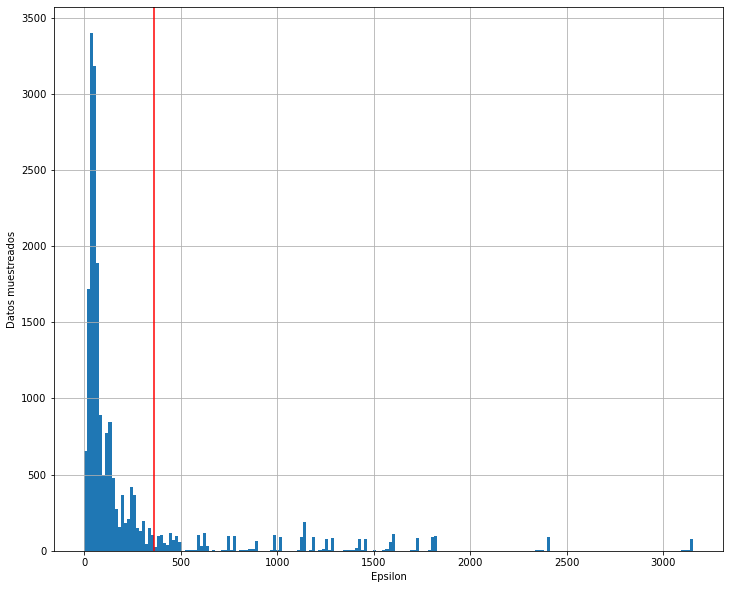

In [12]:

def k_distances2(x, k):
    #x: dataset        k: #NN
    
    dim0 = x.shape[0]
    dim1 = x.shape[1]
    p = -2*x.dot(x.T) + np.sum(x**2, axis = 1).T + np.repeat(np.sum(x**2, axis = 1),dim0, axis = 0).reshape(dim0,dim0)
    p = np.sqrt(abs(p)) #EUCLIDEAN DISTANCE
    p.sort(axis = 1)
    p = p[:,:k]
    pm = np.sort(p.flatten())
    
    return p, pm

m, m2 = k_distances2(dataset.to_numpy(), 100)
plt.figure(figsize=(12, 10))
plt.hist(m2, bins = 200)
plt.xlabel('Epsilon') #epsilon distance
plt.ylabel('Datos muestreados') 
plt.axvline(x=360, color='r')
plt.grid(True)

In [13]:
import math
from math import sqrt, log, floor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from statistics import mean
from fastdtw import fastdtw
from scipy import stats
from scipy.spatial.distance import pdist

timeSeries = pd.read_csv(my_path_py+'\\DatosRaw\\TimeSerie_Incidencia2009al2013.csv', sep=',')
timeSeries = timeSeries.drop('Unnamed: 0', axis=1)
n= timeSeries.shape[0]

#Correlation
def corr(x, y):
    r=np.dot(x-mean(x),y-mean(y))/((np.linalg.norm(x-mean(x)))*(np.linalg.norm(y-mean(y))))
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

#Spearman
def scorr(x, y):
    r = stats.spearmanr(x, y)[0]
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r


In [14]:
#Corr
corr_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        corr_dist[i,j] = corr(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())

#scorr
scorr_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        scorr_dist[i,j] = scorr(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())

In [15]:
epsi = np.arange (0.01, 5, 0.01)
sil_corr = []
sil_spear =[]
for i in epsi:
    
    #CON CORRELATION
    try:
        DB_corr = DBSCAN(eps=i, min_samples=4).fit_predict(corr_dist)
        #print("DBSCAN + corr distance: ")
        sil_corr.append(silhouette_score(corr_dist, DB_corr))
    except:
        sil_corr.append(np.nan)
    #CON SPEARMAN
    try:
        DB_scorr = DBSCAN(eps=i, min_samples=4).fit_predict(scorr_dist)
        #print("DBSCAN + scorr distance: ")
        sil_spear.append(silhouette_score(scorr_dist, DB_scorr))
    except:
        sil_spear.append(np.nan)

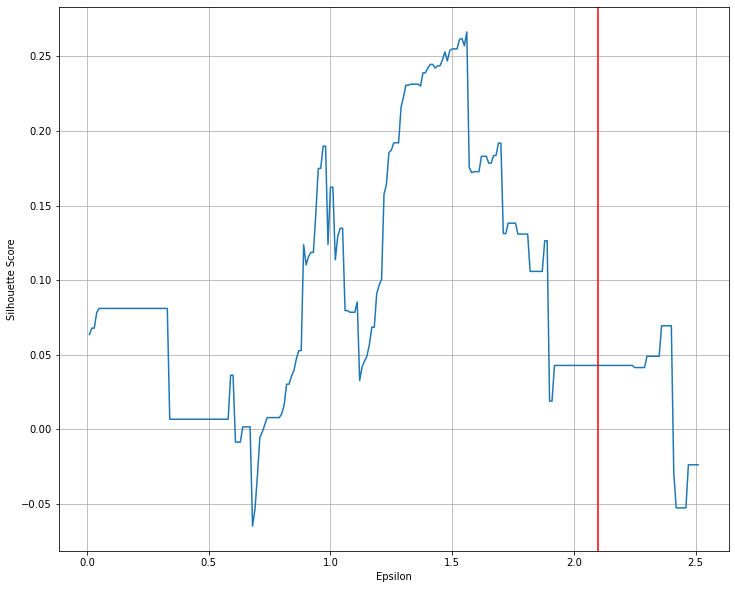

In [16]:
plt.figure(figsize=(12, 10))
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.plot(epsi, sil_corr)
plt.axvline(x=2.1, color='r')
plt.grid(True)


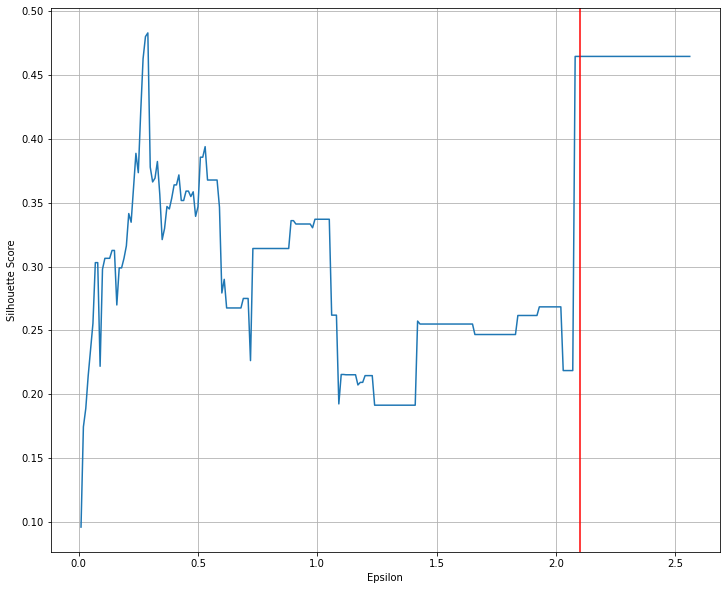

In [17]:
plt.figure(figsize=(12, 10))
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.plot(epsi, sil_spear)
plt.axvline(x=2.1, color='r')
plt.grid(True)

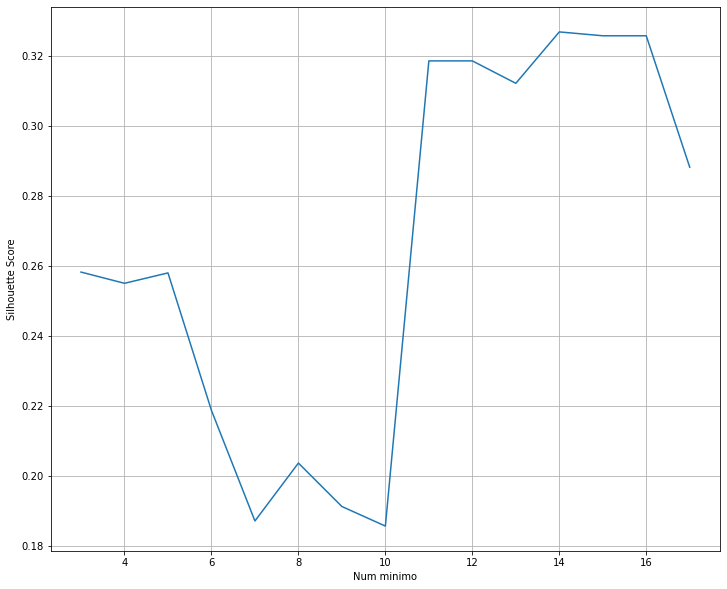

In [18]:
num_minimo = list(range(3,18))
sil_corr = []
sil_spear =[]
for i in num_minimo:
    
    #CON CORRELATION
    try:
        DB_corr = DBSCAN(eps=1.5, min_samples=i).fit_predict(corr_dist)
        sil_corr.append(silhouette_score(corr_dist, DB_corr))
    except:
        sil_corr.append(np.nan)
    #CON SPEARMAN
    try:
        DB_scorr = DBSCAN(eps=1.5, min_samples=i).fit_predict(scorr_dist)
        sil_spear.append(silhouette_score(scorr_dist, DB_scorr))
    except:
        sil_spear.append(np.nan)
        
plt.figure(figsize=(12, 10))
plt.xlabel('Num minimo')
plt.ylabel('Silhouette Score')
plt.plot(num_minimo, sil_corr)
plt.grid(True)
